In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('Deepfake_audio'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Deepfake_audio\DEMONSTRATION\DEMONSTRATION\linus-original-DEMO.mp3
Deepfake_audio\DEMONSTRATION\DEMONSTRATION\linus-to-musk-DEMO.mp3
Deepfake_audio\KAGGLE\DATASET-balanced.csv
Deepfake_audio\KAGGLE\AUDIO\FAKE\biden-to-linus.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\biden-to-margot.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\biden-to-musk.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\biden-to-Obama.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\biden-to-ryan.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\biden-to-taylor.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\biden-to-Trump.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\linus-to-biden.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\linus-to-margot.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\linus-to-musk.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\linus-to-obama.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\linus-to-ryan.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\linus-to-taylor.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\linus-to-trump.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\margot-to-biden.wav
Deepfake_audio\KAGGLE\AUDIO\FAKE\margot-to-

In [2]:
import os
import librosa
import pandas as pd
import numpy as np
import time
import shutil
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment

# CSV

label  REAL -> 0, FAKE -> 1

In [3]:
file = pd.read_csv('Deepfake_audio/KAGGLE/DATASET-balanced.csv')

file['LABEL'] = file['LABEL'].map({'REAL': 0, 'FAKE': 1})

print(file.head())

labels_csv = file['LABEL']
data_csv = file.drop(columns=['LABEL'])

   chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.338055  0.027948        2842.948867         4322.916759  6570.586186   
1     0.443766  0.037838        2336.129597         3445.777044  3764.949874   
2     0.302528  0.056578        2692.988386         2861.133180  4716.610271   
3     0.319933  0.031504        2241.665382         3503.766175  3798.641521   
4     0.420055  0.016158        2526.069123         3102.659519  5025.077899   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.041050 -462.169586   90.311272  19.073769  24.046888  ...   
1            0.047730 -409.413422  120.348808  -7.161531   5.114784  ...   
2            0.080342 -318.996033  120.490273 -24.625771  23.891073  ...   
3            0.047180 -404.636749  136.320908   2.308172  -3.907071  ...   
4            0.051905 -410.497925  152.731400 -18.266771  51.993462  ...   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17 

In [4]:
data_csv.shape

(11778, 26)

In [5]:
labels_csv.shape

(11778,)

In [6]:
data_csv.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-14.181895,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,0.372541,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-3.099179,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,1.513633,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,11.086248,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998


In [7]:
real_count = (labels_csv == 0).sum()
print("Number of '0' data: ", real_count)

Number of '0' data:  5889


In [8]:
real_count = (labels_csv == 1).sum()
print("Number of '1' data: ", real_count)


Number of '1' data:  5889


**Your dataset consists of 11,778 data instances, each with 26 features. The labels are categorized into two classes: FAKE and REAL, each containing 5,889 instances.**

**Check what values each feature holds**

## 1. Train your model using only the data instances with the label 'REAL'

In [9]:
real_train_data, real_train_labels, real_test_data, real_test_labels = data_csv[6089:], labels_csv[6089:], data_csv[5689:6089], labels_csv[5689:6089]

In [15]:
knn = KNeighborsClassifier()
xgb = XGBClassifier(eval_metric='logloss')
rf = RandomForestClassifier()

models = [knn, xgb, rf]
model_names = ['KNN', 'XGBoost', 'RandomForest']

for model, name in zip(models, model_names):
    start_time = time.time()
    model.fit(real_train_data, real_train_labels)
    end_time = time.time()
    print(f"Training time for {name}: ", end_time - start_time)

    # 10-fold cross-validation 수행
    scores = cross_val_score(model, real_train_data, real_train_labels, cv=10, scoring='accuracy')
    print(f"10-fold cross-validation accuracy for {name}: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))



Training time for KNN:  0.004000663757324219
10-fold cross-validation accuracy for KNN: 1.000 (+/- 0.000)
Training time for XGBoost:  0.08336472511291504


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

10-fold cross-validation accuracy for XGBoost: 1.000 (+/- 0.000)
Training time for RandomForest:  0.17203426361083984
10-fold cross-validation accuracy for RandomForest: 1.000 (+/- 0.000)


**Training dataset consists of 5,689 data instances with the label "REAL." The test dataset is composed of 200 instances with the label "REAL" and 200 instances with the label "FAKE."**

In [16]:

models = [knn, xgb, rf]
model_names = ['KNN', 'XGBoost', 'RandomForest']

for model, name in zip(models, model_names):
    start_time = time.time()
    predictions = model.predict(real_test_data)
    end_time = time.time()
    print(f"Prediction time for {name}: ", end_time - start_time)

    # Print the counts of 0s and 1s in the prediction results
    unique, counts = np.unique(predictions, return_counts=True)
    print(f"Counts of 0 and 1 in predictions for {name}: ", dict(zip(unique, counts)))

Prediction time for KNN:  0.05055117607116699
Counts of 0 and 1 in predictions for KNN:  {0: 400}
Prediction time for XGBoost:  0.006022214889526367
Counts of 0 and 1 in predictions for XGBoost:  {0: 400}
Prediction time for RandomForest:  0.011001825332641602
Counts of 0 and 1 in predictions for RandomForest:  {0: 400}


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [17]:
k = real_test_labels

models = [knn, xgb, rf]
model_names = ['KNN', 'XGBoost', 'RandomForest']

for model, name in zip(models, model_names):
    start_time = time.time()
    predictions = model.predict(real_test_data)
    end_time = time.time()
    print(f"Prediction time for {name}: ", end_time - start_time)

    unique, counts = np.unique(predictions, return_counts=True)
    print(f"Counts of 0 and 1 in predictions for {name}: ", dict(zip(unique, counts)))

    precision = precision_score(k, predictions)
    recall = recall_score(k, predictions)
    f1 = f1_score(k, predictions)
    roc_auc = roc_auc_score(k, predictions)

    print(f"Precision for {name}: ", precision)
    print(f"Recall for {name}: ", recall)
    print(f"F1 Score for {name}: ", f1)
    print(f"ROC-AUC Score for {name}: ", roc_auc)

Prediction time for KNN:  0.05101156234741211
Counts of 0 and 1 in predictions for KNN:  {0: 400}
Precision for KNN:  0.0
Recall for KNN:  0.0
F1 Score for KNN:  0.0
ROC-AUC Score for KNN:  0.5
Prediction time for XGBoost:  0.005000591278076172
Counts of 0 and 1 in predictions for XGBoost:  {0: 400}
Precision for XGBoost:  0.0
Recall for XGBoost:  0.0
F1 Score for XGBoost:  0.0
ROC-AUC Score for XGBoost:  0.5
Prediction time for RandomForest:  0.011986494064331055
Counts of 0 and 1 in predictions for RandomForest:  {0: 400}
Precision for RandomForest:  0.0
Recall for RandomForest:  0.0
F1 Score for RandomForest:  0.0
ROC-AUC Score for RandomForest:  0.5


F:\anaconda3\envs\BE\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\ana

It seems like your models are predicting only one class (0 for 'REAL'), resulting in ROC-AUC scores being the only metric with non-zero values, while other metrics show no variation.

In [ ]:
models = [knn, xgb, rf]
model_names = ['KNN', 'XGBoost', 'Random Forest']

for model, name in zip(models, model_names):
    predictions = model.predict(real_test_data)

    incorrect_count = 0
    for i in range(len(real_test_data)):
        if predictions[i] != real_test_labels.iloc[i]:  
            incorrect_count += 1

    # Print the number of samples that failed to predict
    print(f"The number of incorrect predictions for {name} is {incorrect_count}")

It seems that the XGBoost model is predicting all instances as "REAL," and it's not able to correctly classify any instances as "FAKE." The discrepancy between the original labels and the predictions is resulting in a high count (400) of misclassified instances.

**The accuracy obtained through cross-validation was 1.00. The reason for this is that only the REAL label data was used for both training and testing. The model predicts all instances in the test data as REAL.**

## 2. Train the model with data that has an even distribution of labels between REAL and FAKE.

In [18]:
data_train, data_test, labels_train, labels_test = train_test_split(data_csv, labels_csv, test_size=0.2, random_state=42)

In [19]:
knn_2 = KNeighborsClassifier()
xgb_2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
rf_2 = RandomForestClassifier()
# 모델 리스트
models = [knn_2, xgb_2, rf_2]
model_names = ['KNN', 'XGBoost', 'RandomForest']

for model, name in zip(models, model_names):
    # Measuring the training start time
    start_time = time.time()

    # learning on training data
    model.fit(data_train, labels_train)

    # Measuring the training end time
    end_time = time.time()
    print(f"Training time for {name}: ", end_time - start_time)

    # 5-fold cross-validation 
    scores = cross_val_score(model, data_train, labels_train, cv=10, scoring='accuracy')
    print(f"5-fold cross-validation accuracy for {name}: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Training time for KNN:  0.003928661346435547
5-fold cross-validation accuracy for KNN: 0.801 (+/- 0.022)


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

Training time for XGBoost:  0.729684591293335


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated an

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

5-fold cross-validation accuracy for XGBoost: 0.990 (+/- 0.007)
Training time for RandomForest:  9.144041776657104
5-fold cross-validation accuracy for RandomForest: 0.986 (+/- 0.005)


In [20]:
models = [knn_2, xgb_2, rf_2]
model_names = ['KNN', 'XGBoost', 'Random Forest']

for model, name in zip(models, model_names):
    predictions = model.predict(data_test)

    incorrect_count = sum(1 for i in range(len(predictions)) if predictions[i] != labels_test.iloc[i])

    print(f"The number of incorrect predictions for {name} is {incorrect_count}")

The number of incorrect predictions for KNN is 471
The number of incorrect predictions for XGBoost is 15
The number of incorrect predictions for Random Forest is 25


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [21]:
real_test_labels = labels_test

models = [knn_2, xgb_2, rf_2]
model_names = ['KNN', 'XGBoost', 'RandomForest']

for model, name in zip(models, model_names):
    start_time = time.time()
    predictions = model.predict(data_test)
    end_time = time.time()
    print(f"Prediction time for {name}: ", end_time - start_time)

    # To print the count of 0s and 1s in the prediction results
    unique, counts = np.unique(predictions, return_counts=True)
    print(f"Counts of 0 and 1 in predictions for {name}: ", dict(zip(unique, counts)))

    precision = precision_score(real_test_labels, predictions)
    recall = recall_score(real_test_labels, predictions)
    f1 = f1_score(real_test_labels, predictions)
    roc_auc = roc_auc_score(real_test_labels, predictions)

    print(f"Precision for {name}: ", precision)
    print(f"Recall for {name}: ", recall)
    print(f"F1 Score for {name}: ", f1)
    print(f"ROC-AUC Score for {name}: ", roc_auc)
    print("====================================================================")

Prediction time for KNN:  0.17251276969909668
Counts of 0 and 1 in predictions for KNN:  {0: 1122, 1: 1234}
Precision for KNN:  0.7925445705024311
Recall for KNN:  0.8197820620284996
F1 Score for KNN:  0.8059332509270705
ROC-AUC Score for KNN:  0.7998308418482997
Prediction time for XGBoost:  0.008006811141967773
Counts of 0 and 1 in predictions for XGBoost:  {0: 1166, 1: 1190}
Precision for XGBoost:  0.9949579831932773
Recall for XGBoost:  0.9924559932942163
F1 Score for XGBoost:  0.9937054133445238
ROC-AUC Score for XGBoost:  0.9936484609635312
Prediction time for RandomForest:  0.03800845146179199
Counts of 0 and 1 in predictions for RandomForest:  {0: 1160, 1: 1196}
Precision for RandomForest:  0.9882943143812709
Recall for RandomForest:  0.9907795473595976
F1 Score for RandomForest:  0.9895353704478861
ROC-AUC Score for RandomForest:  0.9893708570847859


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [22]:
from sklearn.metrics import accuracy_score

for model, name in zip(models, model_names):
    predictions = model.predict(data_test)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"Test Accuracy for {name}: ", accuracy)

Test Accuracy for KNN:  0.8000848896434635
Test Accuracy for XGBoost:  0.9936332767402377
Test Accuracy for RandomForest:  0.9893887945670629


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


**I have observed that XGBoost performs the best in terms of both time and accuracy. I have decided to use the XGBoost model**

[0]	validation_0-logloss:0.51842	validation_1-logloss:0.52570
[1]	validation_0-logloss:0.40329	validation_1-logloss:0.41642
[2]	validation_0-logloss:0.32380	validation_1-logloss:0.34280
[3]	validation_0-logloss:0.26778	validation_1-logloss:0.28710
[4]	validation_0-logloss:0.22699	validation_1-logloss:0.24702
[5]	validation_0-logloss:0.19366	validation_1-logloss:0.21283
[6]	validation_0-logloss:0.16953	validation_1-logloss:0.19064
[7]	validation_0-logloss:0.15244	validation_1-logloss:0.17440
[8]	validation_0-logloss:0.12882	validation_1-logloss:0.15235
[9]	validation_0-logloss:0.11639	validation_1-logloss:0.14082
[10]	validation_0-logloss:0.10021	validation_1-logloss:0.12502
[11]	validation_0-logloss:0.09156	validation_1-logloss:0.11758
[12]	validation_0-logloss:0.08161	validation_1-logloss:0.10711
[13]	validation_0-logloss:0.07441	validation_1-logloss:0.10019


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

[14]	validation_0-logloss:0.06565	validation_1-logloss:0.09097
[15]	validation_0-logloss:0.06136	validation_1-logloss:0.08755
[16]	validation_0-logloss:0.05277	validation_1-logloss:0.07854
[17]	validation_0-logloss:0.04710	validation_1-logloss:0.07445
[18]	validation_0-logloss:0.04232	validation_1-logloss:0.06902
[19]	validation_0-logloss:0.03888	validation_1-logloss:0.06597
[20]	validation_0-logloss:0.03674	validation_1-logloss:0.06379
[21]	validation_0-logloss:0.03334	validation_1-logloss:0.06039
[22]	validation_0-logloss:0.03122	validation_1-logloss:0.05846
[23]	validation_0-logloss:0.02843	validation_1-logloss:0.05537
[24]	validation_0-logloss:0.02552	validation_1-logloss:0.05218
[25]	validation_0-logloss:0.02392	validation_1-logloss:0.05126
[26]	validation_0-logloss:0.02194	validation_1-logloss:0.04905
[27]	validation_0-logloss:0.02017	validation_1-logloss:0.04718
[28]	validation_0-logloss:0.01947	validation_1-logloss:0.04614
[29]	validation_0-logloss:0.01852	validation_1-logloss:

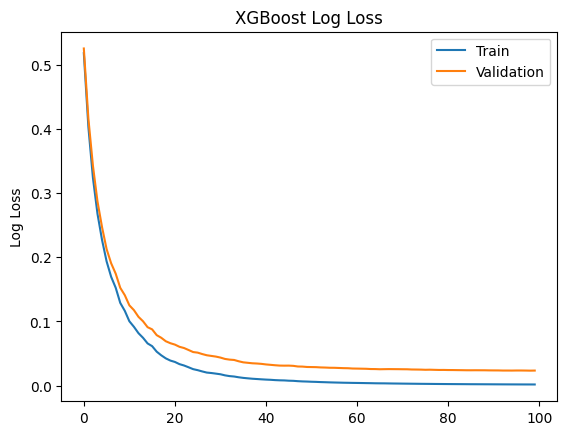

In [27]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

xgb_2 = XGBClassifier(eval_metric="logloss")

# eval_set
eval_set = [(data_train, labels_train), (data_test, labels_test)]

xgb_2.fit(data_train, labels_train, eval_set=eval_set, verbose=True)

results = xgb_2.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots() 
ax.plot(x_axis, results['validation_0']['logloss'], label='Train') 
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation') 
ax.legend() 
plt.ylabel('Log Loss') 
plt.title('XGBoost Log Loss') 
plt.show()


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

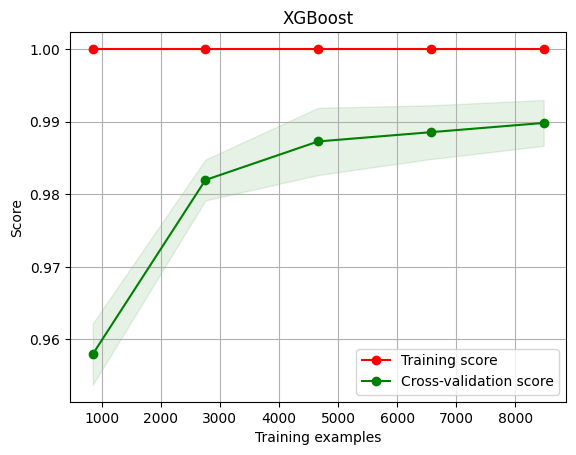

In [28]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# XGBoost Draw learning curves for the model
plot_learning_curve(xgb_2, 'XGBoost', data_train, labels_train, cv=10)
plt.show()


## Let's input new data

In [29]:
n_fft = 2048
hop_length = 512

def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.mean(np.squeeze(chroma_stft.T)) if not flatten else np.mean(np.ravel(chroma_stft.T))

def rms(data, frame_length=2048, hop_length=512):
    rms = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.mean(np.squeeze(rms))

def spectral_centroid(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.mean(np.squeeze(spectral_centroid))

def spectral_bandwidth(data, sr, frame_length=2048, hop_length=512):
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.mean(np.squeeze(spectral_bandwidth))

def spectral_rolloff(data, sr, frame_length=2048, hop_length=512):
    spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.mean(np.squeeze(spectral_rolloff))

def zero_crossing_rate(data, frame_length=2048, hop_length=512):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.mean(np.squeeze(zero_crossing_rate))

def calculate_mfcc(data, sr, n_mfcc=20, frame_length=2048, hop_length=512):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc_feature.T, axis=0)

def split_audio_into_chunks(data, sr):
    frame_length = sr  
    frames = librosa.util.frame(data, frame_length=frame_length, hop_length=frame_length)
    return frames.T

def balance_data(df):
    X = df.drop('LABEL', axis=1)
    y = df['LABEL']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test

In [31]:
REAL_folder = 'Deepfake_audio/KAGGLE/AUDIO/REAL'

for filename in os.listdir(REAL_folder):
    file_path = os.path.join(REAL_folder, filename)
    data, sr = librosa.load(file_path, sr=None)

    chunks = split_audio_into_chunks(data, sr)
    features = []

    for chunk in chunks:
        chroma_stft_result = chroma_stft(chunk, sr)
        rms_result = rms(chunk)
        spectral_centroid_result = spectral_centroid(chunk, sr)
        spectral_bandwidth_result = spectral_bandwidth(chunk, sr)
        spectral_rolloff_result = spectral_rolloff(chunk, sr)
        zero_crossing_rate_result = zero_crossing_rate(chunk)
        mfcc_result = calculate_mfcc(chunk, sr)

        feature = {
            'chroma_stft': chroma_stft_result,
            'rms': rms_result,
            'spectral_centroid': spectral_centroid_result,
            'spectral_bandwidth': spectral_bandwidth_result,
            'rolloff': spectral_rolloff_result,
            'zero_crossing_rate': zero_crossing_rate_result
        }
        for i, mfcc in enumerate(mfcc_result):
            feature[f'mfcc{i+1}'] = mfcc
        feature['LABEL'] = '0'

        features.append(feature)

    df = pd.DataFrame(features)
    X_train, X_test, y_train, y_test = balance_data(df)
    df.to_csv(f'{filename}_features.csv', index=False)

In [32]:
FAKE_folder = 'Deepfake_audio/KAGGLE/AUDIO/FAKE'

for filename in os.listdir(FAKE_folder):
    file_path = os.path.join(FAKE_folder, filename)
    data, sr = librosa.load(file_path, sr=None)

    chunks = split_audio_into_chunks(data, sr)
    features = []

    for chunk in chunks:
        chroma_stft_result = chroma_stft(chunk, sr)
        rms_result = rms(chunk)
        spectral_centroid_result = spectral_centroid(chunk, sr)
        spectral_bandwidth_result = spectral_bandwidth(chunk, sr)
        spectral_rolloff_result = spectral_rolloff(chunk, sr)
        zero_crossing_rate_result = zero_crossing_rate(chunk)
        mfcc_result = calculate_mfcc(chunk, sr)

        feature = {
            'chroma_stft': chroma_stft_result,
            'rms': rms_result,
            'spectral_centroid': spectral_centroid_result,
            'spectral_bandwidth': spectral_bandwidth_result,
            'rolloff': spectral_rolloff_result,
            'zero_crossing_rate': zero_crossing_rate_result
        }
        for i, mfcc in enumerate(mfcc_result):
            feature[f'mfcc{i+1}'] = mfcc
        feature['LABEL'] = '1'

        features.append(feature)

    df = pd.DataFrame(features)
    X_train, X_test, y_train, y_test = balance_data(df)
    df.to_csv(f'{filename}_features.csv', index=False)

In [33]:
# check feature importance
importances = xgb_2.feature_importances_

# Sort features according to importance and output
indices = np.argsort(importances)[::-1]
for f in range(data_train.shape[1]): 
    print("%2d) %-*s %f" % (f + 1, 30, data_train.columns[indices[f]], importances[indices[f]]))

 1) mfcc2                          0.154799
 2) mfcc18                         0.115304
 3) mfcc9                          0.071517
 4) rms                            0.068582
 5) mfcc12                         0.063206
 6) mfcc4                          0.051075
 7) mfcc8                          0.047240
 8) mfcc17                         0.043977
 9) mfcc19                         0.039876
10) mfcc3                          0.035695
11) mfcc1                          0.030276
12) mfcc6                          0.025518
13) mfcc10                         0.025154
14) spectral_centroid              0.023295
15) mfcc7                          0.023216
16) mfcc11                         0.023106
17) zero_crossing_rate             0.022407
18) mfcc15                         0.020805
19) mfcc16                         0.019839
20) mfcc20                         0.016585
21) mfcc14                         0.015057
22) chroma_stft                    0.014679
23) rolloff                     

In [34]:
file.iloc[5886:5892]

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
5886,0.384512,0.063101,2045.098124,2425.675898,3332.543240,0.057315,-312.345520,175.770859,-12.099794,0.600061,...,3.767448,-5.823318,-5.798408,-1.643402,-12.729777,-6.868438,-4.802541,-15.484475,-14.021510,1
5887,0.509232,0.016556,1888.887039,3189.821694,3174.591594,0.029833,-466.381470,163.459824,7.386739,31.877653,...,5.154534,2.141474,-4.814976,-0.352330,-3.403898,-5.238068,0.066288,-1.768038,-2.838249,1
5888,0.356053,0.043102,2009.824050,2677.834399,3300.554608,0.044806,-366.843658,162.571243,-9.733773,37.762978,...,-6.410048,0.430428,-3.240857,-7.342463,-4.079655,-6.076251,-5.004099,-0.742719,0.265641,1
5889,0.477704,0.014462,3016.778974,3604.604331,5547.475896,0.073273,-405.487885,139.729904,-20.206697,23.558033,...,-3.273046,-1.378102,-4.126157,-4.048576,-6.344575,0.406621,-3.905834,0.207456,-12.308215,0
5890,0.332934,0.050558,1633.899474,2221.860788,2266.331449,0.039969,-341.936218,185.440277,-37.682835,-21.129572,...,-9.211580,-3.900930,0.573838,-5.047585,-5.753800,-8.881322,-8.399917,-4.041532,-9.375943,0
5891,0.465885,0.017526,5013.907561,4163.820516,9618.122573,0.157687,-384.163940,78.506737,-18.514698,57.979454,...,-4.813970,-7.959636,-8.341685,-3.497023,-8.539886,-5.114526,-15.583284,-0.695213,-16.747854,0


## Check code transformation and functioning

**"REAl" label Audio file**

In [35]:
data = pd.read_csv('musk-original.wav_features.csv')

X_sample = data.iloc[:,:-1]
y_sample = data.iloc[:,-1]

In [36]:
data.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.627429,0.081454,993.839347,1426.923041,1785.028287,0.027546,-300.95242,209.95460,0.878760,-8.967664,...,-5.096684,-1.809943,0.489257,-3.473059,-0.346756,1.963360,-1.293067,1.358556,3.238603,0
1,0.717498,0.087296,1166.573492,1298.249899,2094.165881,0.035790,-275.02740,272.05667,-50.074970,-18.682232,...,-5.644960,4.745728,7.430971,-12.809910,-3.055949,6.951242,-7.648923,-4.899377,0.095325,0
2,0.578452,0.128259,1067.315608,1407.532357,1817.946862,0.034191,-281.17900,214.89096,6.685783,-7.799721,...,-3.358134,5.704370,8.247436,5.534484,3.993222,-2.660113,-5.107556,3.994996,3.265320,0
3,0.563615,0.105534,981.316437,1449.141988,1527.619881,0.025458,-285.67892,192.93153,15.332471,-14.959086,...,-4.028444,5.964242,9.843518,2.175697,-2.464315,-1.327150,0.559581,1.986040,-1.057644,0
4,0.597402,0.157136,921.939551,1277.141327,1581.329135,0.023937,-271.48700,217.65726,5.535634,-9.939425,...,-6.166760,2.766062,6.348642,0.241400,-2.550756,-2.476090,-0.143345,5.066152,1.689559,0


In [37]:
predictions = xgb_2.predict(X_sample)
print(predictions[:10])

[0 0 0 0 0 0 0 0 0 0]


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [38]:
predictions = xgb_2.predict(X_sample)
report = classification_report(y_sample, predictions)

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       0.00      0.00      0.00         0

    accuracy                           1.00       600
   macro avg       0.50      0.50      0.50       600
weighted avg       1.00      1.00      1.00       600



F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

**REAL FAKE label data**

In [39]:
data1 = pd.read_csv('musk-original.wav_features.csv')
data2 = pd.read_csv('musk-to-linus.wav_features.csv')

data = pd.concat([data1, data2])

X_sample_2 = data.iloc[:,:-1]
y_sample_2 = data.iloc[:,-1]

predictions_2 = xgb_2.predict(X_sample_2)
report = classification_report(y_sample_2, predictions_2)

print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       600
           1       1.00      0.99      0.99       600

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


## Sample data

### MP3 to wav 

In [40]:
new_dir_path = 'Deepfake_audio\KAGGLE\WORKING\SAMPLE'

os.makedirs(new_dir_path, exist_ok=True)
# MP3 
sound = AudioSegment.from_mp3('Deepfake_audio\KAGGLE\dF AUDIO SAMPLE\Trump_WEF_2018.mp3')

# WAV 
sound.export('Deepfake_audio\KAGGLE\WORKING\SAMPLE\Trump_WEF_2018.wav', format="wav")

<_io.BufferedRandom name='Deepfake_audio\\KAGGLE\\WORKING\\SAMPLE\\Trump_WEF_2018.wav'>

**'real-only' Move to the repository to work on the file**

In [42]:
new_dir_path = 'Deepfake_audio\KAGGLE\WORKING\SAMPLE'

os.makedirs(new_dir_path, exist_ok=True)
# MP3 
sound = AudioSegment.from_mp3('Deepfake_audio\KAGGLE\dF AUDIO SAMPLE\small.mp3')

# WAV 
sound.export('Deepfake_audio\KAGGLE\WORKING\SAMPLE\smalls.wav', format="wav")

<_io.BufferedRandom name='Deepfake_audio\\KAGGLE\\WORKING\\SAMPLE\\smalls.wav'>

Cutting audio data into 10-minute intervals for data exceeding 10 minutes

In [44]:
from pydub import AudioSegment

# load
audio = AudioSegment.from_wav("Deepfake_audio\KAGGLE\WORKING\SAMPLE\Trump_WEF_2018.wav")


ten_minutes = 10*60*1000

# List to store split audio files.
chunks = []

# Split an audio file into 10-minute intervals.
for i in range(0, len(audio), ten_minutes):
    chunks.append(audio[i:i+ten_minutes])

# Save each split audio file
for i, chunk in enumerate(chunks):
    chunk.export(f"Deepfake_audio\KAGGLE\WORKING\SAMPLE\chunk{i}.wav", format="wav")


### convert a WAV file to a CSV file

In [45]:
Sample_folder = 'Deepfake_audio\KAGGLE\WORKING\SAMPLE'

for filename in os.listdir(Sample_folder):
    file_path = os.path.join(Sample_folder, filename)
    data, sr = librosa.load(file_path, sr=None)

    chunks = split_audio_into_chunks(data, sr)
    features = []

    for chunk in chunks:
        chroma_stft_result = chroma_stft(chunk, sr)
        rms_result = rms(chunk)
        spectral_centroid_result = spectral_centroid(chunk, sr)
        spectral_bandwidth_result = spectral_bandwidth(chunk, sr)
        spectral_rolloff_result = spectral_rolloff(chunk, sr)
        zero_crossing_rate_result = zero_crossing_rate(chunk)
        mfcc_result = calculate_mfcc(chunk, sr)

        feature = {
            'chroma_stft': chroma_stft_result,
            'rms': rms_result,
            'spectral_centroid': spectral_centroid_result,
            'spectral_bandwidth': spectral_bandwidth_result,
            'rolloff': spectral_rolloff_result,
            'zero_crossing_rate': zero_crossing_rate_result
        }
        for i, mfcc in enumerate(mfcc_result):
            feature[f'mfcc{i+1}'] = mfcc
        feature['LABEL'] = '0'

        features.append(feature)

    df = pd.DataFrame(features)
    X_train, X_test, y_train, y_test = balance_data(df)
    df.to_csv(f'Deepfake_audio\KAGGLE\WORKING\SAMPLE\{filename}_features.csv', index=False)

F:\anaconda3\envs\BE\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1765 test

In [47]:
data1 = pd.read_csv('Deepfake_audio\KAGGLE\WORKING\SAMPLE\chunk0.wav_features.csv')
data2 = pd.read_csv('Deepfake_audio\KAGGLE\WORKING\SAMPLE\chunk1.wav_features.csv')
data3 = pd.read_csv('Deepfake_audio\KAGGLE\WORKING\SAMPLE\chunk2.wav_features.csv')
data4 = pd.read_csv('Deepfake_audio\KAGGLE\WORKING\SAMPLE\smalls.wav_features.csv')

data = pd.concat([data1, data2, data3, data4])

X_sample_3 = data.iloc[:,:-1]
y_sample_3 = data.iloc[:,-1]

start_time = time.time()
predictions_3 = xgb_2.predict(X_sample_3)
end_time = time.time()
report = classification_report(y_sample_3, predictions_3)

print(f"Prediction time for {name}: ", end_time - start_time)
print(report)

Prediction time for RandomForest:  0.006530046463012695
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      1765
           1       0.00      0.00      0.00         0

    accuracy                           0.73      1765
   macro avg       0.50      0.37      0.42      1765
weighted avg       1.00      0.73      0.85      1765



F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\si

In [48]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_sample_3, predictions_3)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.7342776203966006


In [49]:
data1 = pd.read_csv('Deepfake_audio\KAGGLE\WORKING\SAMPLE\chunk0.wav_features.csv')
data2 = pd.read_csv('Deepfake_audio\KAGGLE\WORKING\SAMPLE\chunk1.wav_features.csv')
data3 = pd.read_csv('Deepfake_audio\KAGGLE\WORKING\SAMPLE\smalls.wav_features.csv')
data4 = pd.read_csv('Deepfake_audio\KAGGLE\WORKING\SAMPLE\chunk2.wav_features.csv')
data = pd.concat([data1, data2, data3])

X_sample_3 = data.iloc[:,:-1]
y_sample_3 = data.iloc[:,-1]

X_sample_4 = data.iloc[:,:-1]
y_sample_4 = data.iloc[:,-1]

data_train_sample = pd.concat([data_train, X_sample_3])
labels_train_sample = pd.concat([labels_train, y_sample_3])
data_test_sample = pd.concat([data_test, X_sample_4])
labels_test_sample = pd.concat([labels_test, y_sample_4])

In [50]:
xgb_3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_3.fit(data_train_sample, labels_train_sample)

start_time = time.time()
predictions_sample = xgb_3.predict(data_test_sample)
end_time = time.time()

report = classification_report(labels_test_sample, predictions_sample)

print(f"Prediction time for {name}: ", end_time - start_time)
print(report)

F:\anaconda3\envs\BE\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated an

Prediction time for RandomForest:  0.008001327514648438
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2480
           1       0.99      0.99      0.99      1193

    accuracy                           0.99      3673
   macro avg       0.99      0.99      0.99      3673
weighted avg       0.99      0.99      0.99      3673



F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [51]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(labels_test_sample, predictions_sample)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.9940103457664035


In [52]:
k = labels_test_sample

models = [xgb_3]
model_names = ['XGBoost']

for model, name in zip(models, model_names):
    start_time = time.time()
    predictions = model.predict(data_test_sample)
    end_time = time.time()
    print(f"Prediction time for {name}: ", end_time - start_time)

    unique, counts = np.unique(predictions, return_counts=True)
    print(f"Counts of 0 and 1 in predictions for {name}: ", dict(zip(unique, counts)))

    precision = precision_score(k, predictions)
    recall = recall_score(k, predictions)
    f1 = f1_score(k, predictions)
    roc_auc = roc_auc_score(k, predictions)

    print(f"Precision for {name}: ", precision)
    print(f"Recall for {name}: ", recall)
    print(f"F1 Score for {name}: ", f1)
    print(f"ROC-AUC Score for {name}: ", roc_auc)

Prediction time for XGBoost:  0.008051872253417969
Counts of 0 and 1 in predictions for XGBoost:  {0: 2490, 1: 1183}
Precision for XGBoost:  0.9949281487743026
Recall for XGBoost:  0.9865884325230512
F1 Score for XGBoost:  0.9907407407407406
ROC-AUC Score for XGBoost:  0.9920845388421707


F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
F:\anaconda3\envs\BE\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [53]:
import joblib

# Save the trained XGBoost model to a file
model_filename = 'FakeAudio.joblib'
joblib.dump(xgb_3, model_filename)
print(f"XGBoost model saved to {model_filename}")



XGBoost model saved to FakeAudio.joblib
